In [14]:
#bool8 still in use in gym's librairy for some reason..
!pip uninstall numpy -y
!pip install numpy==1.23.5

import numpy as np
import random
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.distributions import Categorical
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter

from gym.envs import register
import gym
import gym.spaces as Space

np.bool8 = np.bool_

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
  Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl (14.6 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
class Actor(nn.Module):
    """
    Purpose: Implements the actor component of an A2C reinforcement learning algorithm.
    The actor generates an action distribution given an input state allowing the agent to 
    select actions based on this distribution.

    Arguments:
        state_dim (int): Dimension of the input state space.
        n_actions (int): Number of possible actions the agent can take.
        hidden_size (int): Number of units in the hidden layers.
        activation (nn.Module, optional): Activation function for the hidden layers (default: nn.Tanh).

    Output:
        forward(X): Produces a torch.distributions.Normal object with mean and standard deviation
        representing the action distribution for the given input state.
    """
    def __init__(self, state_dim, n_actions, hidden_size, activation=nn.Tanh):
        super().__init__()
        self.n_actions = n_actions
        self.hidden_size = hidden_size
        self.model = nn.Sequential(
            nn.Linear(state_dim, self.hidden_size),
            activation(),
            nn.Dropout(p=0.2),
            nn.Linear(self.hidden_size, self.hidden_size),
            activation(),
            nn.Dropout(p=0.2),
            nn.Linear(self.hidden_size, n_actions)
        )
        
        logstds_param = nn.Parameter(torch.full((n_actions,), 0.01))
        self.register_parameter("logstds", logstds_param)
    
    def forward(self, X):
        means = self.model(X)
        stds = torch.clamp(self.logstds.exp(), 1e-3, 50)
        
        return torch.distributions.Normal(means, stds)

In [16]:
class Critic(nn.Module):
    """
    Purpose: Implements the critic component of an A2C reinforcement learning algorithm.
    The critic evaluates the value of a given state, which helps estimate the advantage for 
    policy updates in the actor-critic framework.

    Arguments:
        state_dim (int): Dimension of the input state space.
        hidden_size (int): Number of units in the hidden layers.
        activation (nn.Module, optional): Activation function for the hidden layers (default: nn.Tanh).

    Output:
        forward(X): Produces a scalar value (torch.Tensor) representing the estimated value 
        of the given input state.
    """
    def __init__(self, state_dim, hidden_size, activation=nn.Tanh):
        super().__init__()
        self.hidden_size = hidden_size
        self.model = nn.Sequential(
            nn.Linear(state_dim, self.hidden_size),
            activation(),
            nn.Dropout(p=0.2),
            nn.Linear(self.hidden_size, self.hidden_size),
            activation(),
            nn.Dropout(p=0.2),
            nn.Linear(self.hidden_size, 1),
        )
    
    def forward(self, X):
        return self.model(X)

In [17]:
def discounted_rewards(rewards, dones, gamma):
    """
    Purpose: Computes the discounted cumulative rewards for a sequence of rewards, 
    taking into account terminal states indicated by `dones`.
    """
    ret = 0
    discounted = []
    for reward, done in zip(rewards[::-1], dones[::-1]):
        ret = reward + ret * gamma * (1-done)
        discounted.append(ret)
    
    return discounted[::-1]

In [18]:
def process_memory(memory, gamma=0.99, discount_rewards=True):
    """
    Purpose: Processes a list of experience tuples from an agent's memory into separate 
    tensors for actions, states, next states, rewards, and dones. Optionally applies 
    discounting to rewards.
    """
    actions = []
    states = []
    next_states = []
    rewards = []
    dones = []

    for action, reward, state, next_state, done in memory:
        actions.append(action)
        rewards.append(reward)
        states.append(state)
        next_states.append(next_state)
        dones.append(done)
    
    if discount_rewards:
        if False and dones[-1] == 0:
            rewards = discounted_rewards(rewards + [last_value], dones + [0], gamma)[:-1]
        else:
            rewards = discounted_rewards(rewards, dones, gamma)

    actions = to_tensor(actions).view(-1, 1)
    states = to_tensor(states)
    next_states = to_tensor(next_states)
    rewards = to_tensor(rewards).view(-1, 1)
    dones = to_tensor(dones).view(-1, 1)
    return actions, rewards, states, next_states, dones

def clip_grad_norm_(module, max_grad_norm):
    """
    Purpose: Clips the gradients of the parameters in the optimizer to prevent exploding gradients 
    during backpropagation.
    """
    nn.utils.clip_grad_norm_([p for g in module.param_groups for p in g["params"]], max_grad_norm)

In [19]:
def mish(input):
    """
    Purpose: Implements the Mish activation function, a self-regularizing non-linearity 
    that is smooth and differentiable.
    """
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, input): return mish(input)

In [20]:
class A2CLearner():
    """
    Purpose: Implements the A2C (Advantage Actor-Critic) learning algorithm. The class combines 
    the actor and critic networks to update their parameters through reinforcement learning. 
    It uses the advantage function for updating the actor and the value function for updating the critic.

    Arguments:
        actor (nn.Module): The actor network, responsible for selecting actions based on states.
        critic (nn.Module): The critic network, responsible for evaluating the value of states.
        gamma (float, optional): Discount factor for future rewards (default: 0.99).
        entropy_beta (float, optional): Weight of the entropy term in the actor's loss (default: 0.05).
        actor_lr (float, optional): Learning rate for the actor's optimizer (default: 4e-4).
        critic_lr (float, optional): Learning rate for the critic's optimizer (default: 4e-3).
        max_grad_norm (float, optional): Maximum allowable gradient norm to prevent exploding gradients (default: 0.5).
    
    Output:
        None: Initializes the A2C learner with the provided parameters.
    """
    def __init__(self, actor, critic, gamma=0.99, entropy_beta=0.05,
                 actor_lr=4e-4, critic_lr=4e-3, max_grad_norm=0.5):
        self.gamma = gamma
        self.max_grad_norm = max_grad_norm
        self.actor = actor
        self.critic = critic
        self.entropy_beta = entropy_beta
        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
    
    def learn(self, memory, steps, discount_rewards=True):
        actions, rewards, states, next_states, dones = process_memory(memory, self.gamma, discount_rewards)
        if discount_rewards:
            td_target = rewards
        else:
            td_target = rewards + self.gamma*self.critic(next_states)*(1-dones)
        value = self.critic(states)
        advantage = td_target - value

        # actor
        norm_dists = self.actor(states)
        logs_probs = norm_dists.log_prob(actions)
        entropy = norm_dists.entropy().mean()
        
        actor_loss = (-logs_probs*advantage.detach()).mean() - entropy*self.entropy_beta
        self.actor_optim.zero_grad()
        actor_loss.backward()
        
        clip_grad_norm_(self.actor_optim, self.max_grad_norm)
        writer.add_histogram("gradients/actor",
                             torch.cat([p.grad.view(-1) for p in self.actor.parameters()]), global_step=steps)
        writer.add_histogram("parameters/actor",
                             torch.cat([p.data.view(-1) for p in self.actor.parameters()]), global_step=steps)
        self.actor_optim.step()

        # critic
        critic_loss = F.mse_loss(td_target, value)
        self.critic_optim.zero_grad()
        critic_loss.backward()
        clip_grad_norm_(self.critic_optim, self.max_grad_norm)
        writer.add_histogram("gradients/critic",
                             torch.cat([p.grad.view(-1) for p in self.critic.parameters()]), global_step=steps)
        writer.add_histogram("parameters/critic",
                             torch.cat([p.data.view(-1) for p in self.critic.parameters()]), global_step=steps)
        self.critic_optim.step()
        
        # reports
        writer.add_scalar("losses/log_probs", -logs_probs.mean(), global_step=steps)
        writer.add_scalar("losses/entropy", entropy, global_step=steps) 
        writer.add_scalar("losses/entropy_beta", self.entropy_beta, global_step=steps) 
        writer.add_scalar("losses/actor", actor_loss, global_step=steps)
        writer.add_scalar("losses/advantage", advantage.mean(), global_step=steps)
        writer.add_scalar("losses/critic", critic_loss, global_step=steps)

        return actor_loss.item(), critic_loss.item()


In [21]:
class Runner():
    """
    Purpose: Defines an environment runner that interacts with the environment, collects 
    experiences, and stores them in memory. It tracks the state, actions, rewards, and episodes.

    Arguments:
        env (gym.Env): The environment instance that the agent interacts with.

    Output:
        None: Initializes the Runner with an environment and necessary attributes.
    """
    def __init__(self, env):
        self.env = env
        self.state = None
        self.done = True
        self.steps = 0
        self.episode_reward = 0
        self.episode_rewards = []
    
    def reset(self):
        self.episode_reward = 0
        self.done = False
        self.state = self.env.reset()
    
    def run(self, max_steps, memory=None):
        """Run the environment for a specified number of steps and store the experience in memory."""
        if memory is None:
            memory = []

        for i in range(max_steps):
            if self.done: self.reset()
            # Extract the state (in case it is a tuple of state and info)
            state = self.state[0] if isinstance(self.state, tuple) else self.state
            
            # Pass the state to the actor
            dists = actor(to_tensor(state))
            actions = dists.sample().detach().data.numpy()
            actions_tensor = torch.tensor(actions, dtype=torch.float32)
            action = Categorical(logits=actions_tensor).sample()
            # Take a step in the environment
            next_state, reward, self.done, info, _ = self.env.step(action)

            # Store the experience in memory
            memory.append((action, reward, self.state, next_state, self.done))

            # Update the state
            self.state = next_state
            
            # Track the steps and rewards
            self.steps += 1
            self.episode_reward += reward
            
            # If the episode is done, append the reward and log it
            if self.done:
                self.episode_rewards.append(self.episode_reward)
                if len(self.episode_rewards) % 10 == 0:
                    print("Episode:", len(self.episode_rewards), ", Episode reward:", self.episode_reward)
                writer.add_scalar("episode_reward", self.episode_reward, global_step=self.steps)
        
        return memory, self.episode_reward

In [22]:
def to_tensor(x):
    """
    Purpose:  Purpose: Processes the input `x` based on its type, converting it into a tensor format that 
    can be used by a neural network.
    """
    if isinstance(x, list) and isinstance(x[0], dict):  # List of dictionaries
        x = np.array([[item['agent'], item['target']] for item in x], dtype=np.float32)
    if isinstance(x, dict):  # Handle a dictionary input
        x = np.array(list(x.values()), dtype=np.float32) 
    if isinstance(x, tuple):  # Handle a tuple input
        array_part, dict_part = x
        if not isinstance(array_part, np.ndarray):
            raise ValueError(f"Expected first element of tuple to be ndarray, got {type(array_part)}")
        # Optionally process the dict_part if needed
        x = array_part
    elif not isinstance(x, np.ndarray):  # Handle non-tuple input
        x = np.array(x, dtype=np.float32)
    return torch.from_numpy(x).float()

In [23]:
def init_xavier_weights(m):
    """
    Purpose: Initializes the weights of a given layer using the Xavier (Glorot) initialization method. 
    This method is used for layers in deep neural networks to help with training by maintaining the 
    variance of activations across layers.
    """
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [24]:
def normalize_rewards(r):
    mean = np.mean(r)
    std = np.std(r) + 1e-8  # Add a small epsilon to avoid division by zero
    return (r - mean) / std

In [25]:
class Environment(gym.Env):
    """
    Purpose: 
        This class represents a custom reinforcement learning environment for simulating the management of virtual machine (VM) 
        resources (CPU, memory, disk) and ensuring that the VM's response time meets the target requirement. The agent can adjust 
        the resources allocated to the VM and receive feedback on performance.
    
    Arguments:
        vm (VMClass): An instance of a virtual machine class containing the initial configuration of the VM (e.g., CPU, memory, disk, response time).
        render_mode (str, optional): The rendering mode to use. If provided, it should be either "human" or "rgb_array". Default is None.
    
    Output:
        None: Initializes the environment's parameters.
    """
    def __init__(self, vm, render_mode=None) -> None:
        super(Environment, self).__init__()

        self.metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 20
        }

        self.window_size = 500

        self.vm = vm

        self.observation_space = Space.Dict(
            {
                "agent": Space.Box(0,  self.vm.ResponseTime, shape=(1,), dtype=np.float32),
                "target": Space.Box(0,  self.vm.Requirement_ResTime, shape=(1,), dtype=np.float32)
            }
        )

        self.action_space = Space.Discrete(4)

        # mapping actions to the adjustement we will make to the allocated resources
        self.action_to_adjustement = [
            (-1, 0, 0),
            (0, -1, 0),
            (1, 0, 0),
            (0, 1, 0),
        ]
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        # `self.clock` used to check if the environment is rendered at the correct framerate in human-mode.
        # `self.window` is a reference to the window we draw to.
        self.window = None
        self.clock = None

    def get_obs(self):
        return {"agent": self.vm.ResponseTime,
                "target": self.vm.Requirement_ResTime
                }

    def get_info(self):
        return {
            "cpu": self.vm.VM_CPU_g,
            "memory": self.vm.VM_Mem_g,
            "disk": self.vm.VM_Disk_g,
            "response_time": self.vm.ResponseTime
        }

    def step(self, action):
        """
        Executes an action in the environment, updates the system state, and calculates the reward.
        """
        cpu_adjustment, mem_adjustment, disk_adjustment = self.action_to_adjustement[action]

        print("adjustement", cpu_adjustment, mem_adjustment, disk_adjustment)

        assert any([cpu_adjustment, mem_adjustment, disk_adjustment]
                   ), "Invalid action: all adjustments are zero."

        if cpu_adjustment != 0:
            self.vm.VM_CPU_g = max(1, self.vm.VM_CPU_g + cpu_adjustment)
        if mem_adjustment != 0:
            self.vm.VM_Mem_g = max(1, self.vm.VM_Mem_g + mem_adjustment)
        if disk_adjustment != 0:
            self.vm.VM_Disk_g = max(1, self.vm.VM_Disk_g + disk_adjustment)

        self.vm.calculate_throughput_response_time()

        print("new VM params", self.vm.VM_CPU_g,
              self.vm.VM_Mem_g, self.vm.VM_Disk_g)

        observation = self.get_obs()

        print("observation from stressEnv", observation)

        info = self.get_info()

        terminated = np.bool(
            self.vm.ResponseTime >= self.vm.Requirement_ResTime or
            self.vm.VM_CPU_g > 30 or
            self.vm.VM_Mem_g > 30 or
            self.vm.VM_CPU_g < 2 or
            self.vm.VM_Mem_g < 2
        )

        print("terminated", terminated,
              observation["agent"], observation["target"])

        if terminated:
            reward = -1
        elif self.vm.ResponseTime <= self.vm.Requirement_ResTime:
            efficiency_bonus = 1.5
            resource_penalty = (self.vm.VM_CPU_g + self.vm.VM_Mem_g) / (
                self.vm.VM_CPU_i + self.vm.VM_Mem_i)
            reward = efficiency_bonus - resource_penalty
        return observation, reward, terminated, False, info

    def render(self):
        if self.render_mode == "rgb_array":
            return self.render_frame()

    def render_frame(self):
        if self.window is None:
            pygame.init()
            self.window = pygame.display.set_mode(
                (self.window_size, self.window_size))
            self.clock = pygame.time.Clock()

        if self.render_mode == "rgb_array":
            self.window.fill((255, 255, 255))

            FONT = pygame.font.SysFont('Arial', 30)
            my_gauge = Gauge(
                screen=self.window,
                FONT=FONT,
                x_cord=self.window_size / 2,
                y_cord=self.window_size / 2,
                thickness=30,
                radius=150,
                circle_colour=(128, 128, 128),
                glow=False
            )

            percent = (self.vm.ResponseTime /
                       int(1.1 * self.vm.Requirement_ResTime)) * 100
            my_gauge.draw(percent)

            pygame.display.flip()
            self.clock.tick(self.metadata["render_fps"])

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.vm.ResponseTime = self.vm.ResponseTime_i
        self.vm.VM_CPU_g = self.vm.VM_CPU_i
        self.vm.VM_Mem_g = self.vm.VM_Mem_i
        self.vm.VM_Disk_g = self.vm.VM_Disk_i

        if self.render_mode == "human":
            self.render_frame()

        return self.get_obs()

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()


In [32]:
def initialize_vms(n, vms_cap_cpu, vms_cap_mem, vms_cap_disk, requirement_res_times, sensitivity_collection):
    """
    Purpose:
        Initialize a list of virtual machine (VM) instances with predefined configurations and return the list.
        
    Arguments:
        n (int): The number of virtual machines to initialize.
        vms_cap_cpu (float): The CPU capacity for the VMs.
        vms_cap_mem (float): The memory capacity for the VMs.
        vms_cap_disk (float): The disk capacity for the VMs.
        requirement_res_times (list): A list of required response times for the VMs.
        sensitivity_collection (list): A collection of sensitivity values to initialize the VMs.

    Returns:
        list: A list containing `n` initialized `VirtualMachine` instances.
    """
    vm_list = []

    for i in range(n):
        vm_cpu = random.randint(16, 18)
        vm_mem = random.randint(8, 10)
        vm_disk = random.randint(30, 40)

        vm_res_time = 2600
        vm_sensitivities = sensitivity_collection[i]
        vm_required_time = requirement_res_times[i]

        print(f"VM{i}")
        print(f"Initial Response Time: {vm_res_time}")
        print(
            f"Required Response Time: {vm_required_time}")
        print(f"Sensitivity values (cpu/mem/disk): {vm_sensitivities}")

        vm = VirtualMachine(
            cpu_g=vm_cpu,
            mem_g=vm_mem,
            disk_g=vm_disk,
            cpu_i=vm_cpu,
            mem_i=vm_mem,
            disk_i=vm_disk,
            sensitivity_values=sensitivity_collection[i],
            response_time_i=vm_res_time,
            Requirement_ResTime=vm_required_time,
            Acceptolerance=0.1  
        )

        vm_list.append(vm)

    return vm_list

In [33]:
class VirtualMachine:
    def __init__(self, cpu_g, mem_g, disk_g, cpu_i, mem_i, disk_i, sensitivity_values, response_time_i, Requirement_ResTime, Acceptolerance):
        self.VM_CPU_g = cpu_g
        self.VM_Mem_g = mem_g
        self.VM_Disk_g = disk_g
        self.VM_CPU_i = cpu_i
        self.VM_Mem_i = mem_i
        self.VM_Disk_i = disk_i
        self.VM_SensitivityValues = sensitivity_values
        self.ResponseTime_i = response_time_i
        self.Requirement_ResTime = Requirement_ResTime
        self.Acceptolerance = Acceptolerance
        self.Throughput = 0.0
        self.ResponseTime = 0.0

    def calculate_throughput_response_time(self):
        part1 = (self.VM_CPU_g / self.VM_CPU_i) * self.VM_SensitivityValues[0]
        part2 = (self.VM_Mem_g / self.VM_Mem_i) * self.VM_SensitivityValues[1]
        part3 = (self.VM_Disk_g / self.VM_Disk_i) * \
            self.VM_SensitivityValues[2]
        part4 = sum(self.VM_SensitivityValues)

        self.Throughput = ((part1 + part2 + part3) / part4) * \
            1000.0 / self.ResponseTime_i

        self.ResponseTime = round((1000.0 / self.Throughput) * 100.0) / 100.0


In [35]:
register(
    id="Env-v0",
    entry_point="__main__:Environment",
    kwargs={"render_mode": "rgb_array"}
)

requirement_res_times = [3000, 3050, 3100, 3100]
sensitivity_collection = [
    [0.79, 0.19, 0.01],
    [0.74, 0.24, 0.01],
    [0.27, 0.63, 0.10],
    [0.42, 0.50, 0.07]]

vms = initialize_vms(4, 20, 20, 100, requirement_res_times, sensitivity_collection)
print(f"Initialized {len(vms)} VMs.")

# Running the stress test on the first VM.
vm = vms[0]

env = gym.make("Env-v0", vm=vm, render_mode="rgb_array")

writer = SummaryWriter("runs/mish_activation")

# Config
state_dim = len(env.observation_space.sample())
n_actions = env.action_space.n

actor = Actor(state_dim, n_actions, 128, activation=Mish)
actor.apply(init_xavier_weights)

critic = Critic(state_dim, 128, activation=Mish)
critic.apply(init_xavier_weights)

learner = A2CLearner(actor, critic)
runner = Runner(env)

VM0
Initial Response Time: 2600
Required Response Time: 3000
Sensitivity values (cpu/mem/disk): [0.79, 0.19, 0.01]
VM1
Initial Response Time: 2600
Required Response Time: 3050
Sensitivity values (cpu/mem/disk): [0.74, 0.24, 0.01]
VM2
Initial Response Time: 2600
Required Response Time: 3100
Sensitivity values (cpu/mem/disk): [0.27, 0.63, 0.1]
VM3
Initial Response Time: 2600
Required Response Time: 3100
Sensitivity values (cpu/mem/disk): [0.42, 0.5, 0.07]
Initialized 4 VMs.


In [36]:
steps_on_memory = 15
episodes = 100
episode_length = 20
total_steps = (episode_length*episodes)//steps_on_memory

all_episode_rewards = []
all_actor_losses = []  
all_critic_losses = []

for i in range(total_steps):
    memory, rewards = runner.run(steps_on_memory)
    act_loss, crit_loss = learner.learn(memory, runner.steps, discount_rewards=True)

    all_episode_rewards.append(rewards)  # Save recent rewards
    all_actor_losses.append(act_loss)  # Save latest actor loss
    all_critic_losses.append(crit_loss)  # Save latest critic loss

adjustement 0 1 0
new VM params 16 9 33
observation from stressEnv {'agent': 2539.09, 'target': 3000}
terminated False 2539.09 3000
adjustement 0 1 0
new VM params 16 10 33
observation from stressEnv {'agent': 2480.96, 'target': 3000}
terminated False 2480.96 3000
adjustement 0 1 0
new VM params 16 11 33
observation from stressEnv {'agent': 2425.44, 'target': 3000}
terminated False 2425.44 3000
adjustement -1 0 0
new VM params 15 11 33
observation from stressEnv {'agent': 2543.79, 'target': 3000}
terminated False 2543.79 3000
adjustement -1 0 0
new VM params 14 11 33
observation from stressEnv {'agent': 2674.29, 'target': 3000}
terminated False 2674.29 3000
adjustement -1 0 0
new VM params 13 11 33
observation from stressEnv {'agent': 2818.89, 'target': 3000}
terminated False 2818.89 3000
adjustement -1 0 0
new VM params 12 11 33
observation from stressEnv {'agent': 2980.03, 'target': 3000}
terminated False 2980.03 3000
adjustement 0 1 0
new VM params 12 12 33
observation from stressEn

C:\Users\killi\AppData\Local\Temp\ipykernel_32192\2026244519.py:93: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  terminated = np.bool(


adjustement 0 1 0
new VM params 13 26 33
observation from stressEnv {'agent': 2027.77, 'target': 3000}
terminated False 2027.77 3000
adjustement 0 1 0
new VM params 13 27 33
observation from stressEnv {'agent': 1990.53, 'target': 3000}
terminated False 1990.53 3000
adjustement 0 1 0
new VM params 13 28 33
observation from stressEnv {'agent': 1954.63, 'target': 3000}
terminated False 1954.63 3000
adjustement -1 0 0
new VM params 12 28 33
observation from stressEnv {'agent': 2030.77, 'target': 3000}
terminated False 2030.77 3000
adjustement 0 1 0
new VM params 12 29 33
observation from stressEnv {'agent': 1993.42, 'target': 3000}
terminated False 1993.42 3000
adjustement 0 1 0
new VM params 12 30 33
observation from stressEnv {'agent': 1957.41, 'target': 3000}
terminated False 1957.41 3000
adjustement 0 1 0
new VM params 12 31 33
observation from stressEnv {'agent': 1922.69, 'target': 3000}
terminated True 1922.69 3000
adjustement 0 1 0
new VM params 16 9 33
observation from stressEnv {'

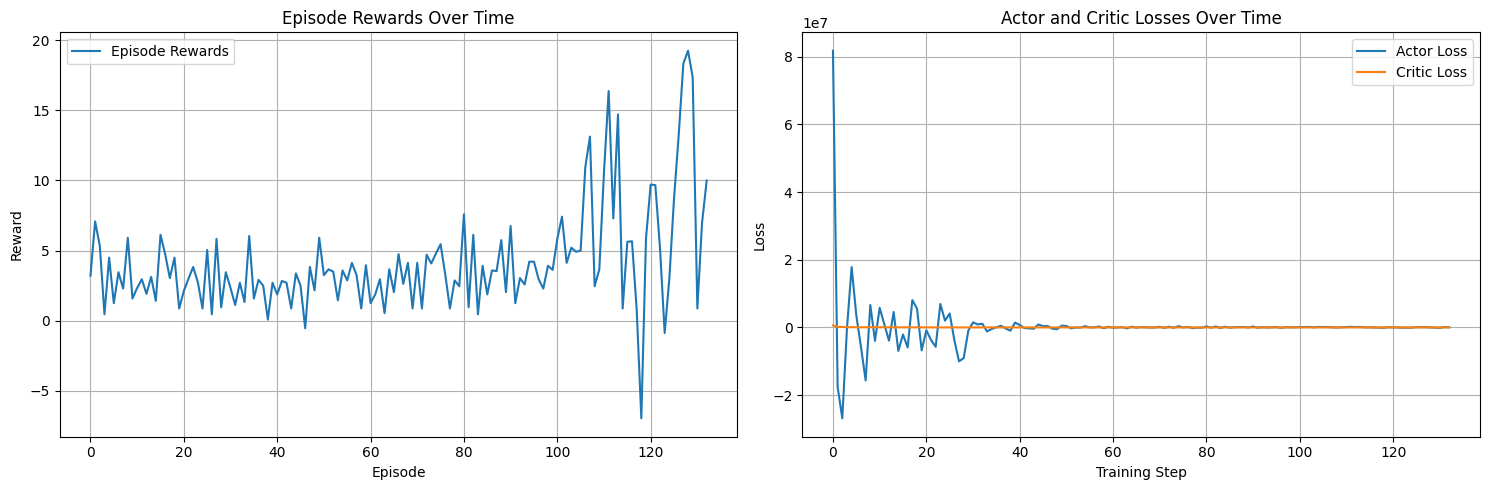

In [37]:
# Plot results
plt.figure(figsize=(15, 5))

# Plot episode rewards
plt.subplot(1, 2, 1)
plt.plot(all_episode_rewards, label="Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Rewards Over Time")
plt.legend()
plt.grid()

# Plot losses
plt.subplot(1, 2, 2)
plt.plot(all_actor_losses, label="Actor Loss")
plt.plot(all_critic_losses, label="Critic Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Actor and Critic Losses Over Time")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()